<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D3%EC%9E%A5%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHAP3 분류

##3.1 MNIST

In [15]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

-딕셔너리 구조: DESCR(데이터셋 설명) + data(샘플, 특성이 행렬) + target(레이블 배열)

In [16]:
X, y=mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


<function matplotlib.pyplot.show(close=None, block=None)>

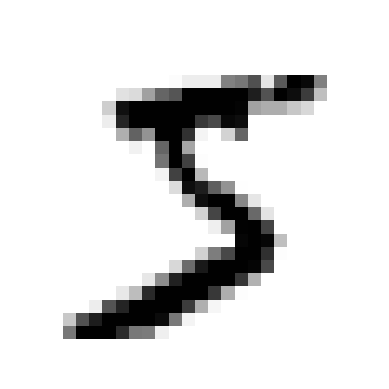

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show

In [20]:
import numpy as np

print(y[0])
y=y.astype(np.uint8)

5


In [21]:
#테스트 세트 만들고 따로 떼어놓기
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

##3.2 이진 분류기 훈련

5-감지기로 5와 5아님 두개의 클래스를 구분하는 이진 분류기

In [22]:
y_train_5=(y_train==5) #5는 True고, 다른 숫자는 모두 false
y_test_5=(y_test==5)

분류 모델 선택해서 훈련시키기


-> 사이킷런의 SGDClassifier 클래스 이용해 확률적 경사 하강법 분류기로 시작(큰 데이터셋 효율적 처리)

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

-SGDClassifier는 훈련시 무작위성 사용하므로 결과 재현하고 싶으면 random_state 매개변수 지정 필요

In [24]:
sgd_clf.predict([some_digit])

array([ True])

##3.3 성능 측정

###3.3.1 교차 검증을 사용한 정확도 측정

cross_val_score() 함수와 거의 같은 작업 수행후 동일한 결과 출력

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred)) #0.9502, 0.96565, 0.96495 출력

0.95035
0.96035
0.9604


StratifiedKFold는 클래스별 비율 유지되도록 폴드 만들기 위해 계층적 샘플링 수행

매 반복서 분류기 객체 복제해 훈련 폴드로 훈련시키고 테스트 폴드로 예측 만들어

-> cross_val_score() 함수로 폴드 3개인 k겹 교차 검증 사용해 SGDClassifier 모델 평가

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [32]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [33]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

-> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 볼 수 있었음

불균형 데이터셋 다룰때 특히 그럼

###3.3.2 오차행렬

오차행렬: 분류기 성능 평가에 좋음

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 처럼 cross_val_predict()는 k겹 교차 검증 수행하지만 평가 점수 반환안하고 각 테스트 폴드서 얻은 예측 반환

confusion_matrix()로 오차행렬 만들어

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행은 실제클래스, 열은 예측 클래스
-> 완벽한 분류기: 진짜 양성+진짜 음성-> 오차행렬 주대각선만 0 아닌 값

-정밀도: 양성 예측의 정확도 = TP/(TP+FP) : TP: 찐 양성, FP: 거짓 양성

-재현율: 민감도, 진짜 양성 비율 = TP/(TP+FN) : FN: 거짓 음성

###3.3.3 정밀도와 재현율

In [36]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [37]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1점수: 정밀도와 재현율의 조화 평균 = 2/(1/정밀도+1/재현율) : f1_score()

In [38]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

-나쁜 동영상 몇개 노출되는 것보다 좋은 동영상 제외되더라도 나쁜 동영상 안나오도록-> 낮은 재현율 높은 정밀도

-감시카메라로 좀도둑 잡아내는 분류기 훈련시 재현율이 높으면 정확도가 낮아도 될 것

-정밀도/재현율 트레이드오프 : 둘 모두를 얻을수 없음 하나 올리면 하나 줄어

###3.3.4 정밀도/재현율 트레이드오프

SGDClassifier 결정함수 사용해 각 샘플 점수 계산

결정 임계값: 가운데 화살표 <- 음성예측 (재현율 높, 정밀도 낮) | 여러가지 임계값 | 양성예측-> (정밀도 높, 재현율 낮)

In [39]:
#원하는 임계값 정해 예측 만들기
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [41]:
threshold=0
y_some_digit_pred = (y_scores>threshold) #true

In [42]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

임계값 높이면 재현율 줄어드는 것 확인-> 적절한 임계값 정하기(cross_val_predict() 사용해 훈련 셋에 있는 모든 샘플 점수 구하고 결정점수 반환 받고 precision_recall_curve()로 모든 임계값에 대한 정밀도, 재현율 계산 가능)

In [43]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [44]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

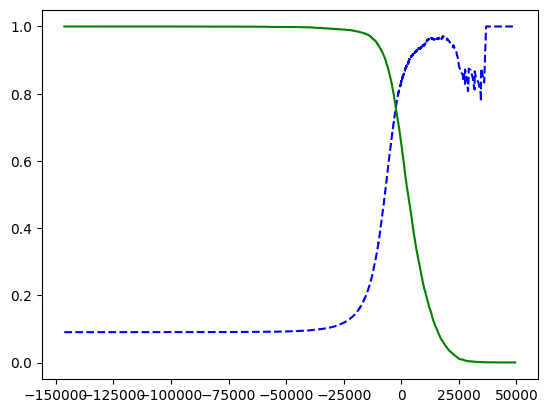

In [46]:
#맷플롯립 이용해 임계값의 함수로 정밀도 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],"b--",label="정밀도")
  plt.plot(thresholds, recalls[:-1],"g-",label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [47]:
#재현율에 대한 정밀도 곡선 그리기

#정밀도 90% 목표 임계값 약 8000

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

#예측에 대한 정밀도 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


###3.3.5 ROC 곡선

수신기 조작 특성 곡선: 거짓 양성 비율에 대한 진짜 양성 비율의 곡선 -> 1-특이도 그래프

roc_curve()함수로 여러 임계값에서 TPR(재현율)과 FPR(거짓양성비율)을 계산해야함

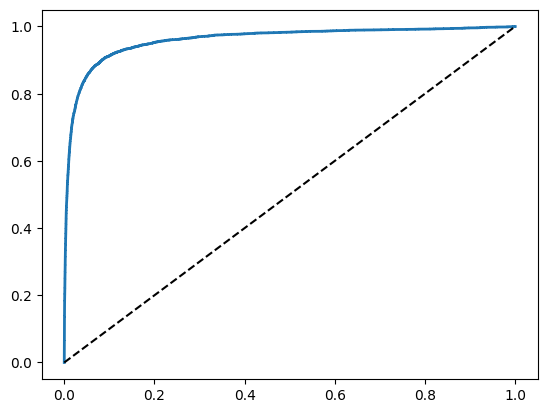

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#맷플롯립 이용해 TPR에 대한 FPR 곡선 그리기

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [49]:
#트레이드오프 존재 -> TPR 높을수록 분류기가 만드는 FPR 증가 : 점선이 완전한 랜덤 분류기의 ROC곡선-> 좋을수록 떨어져야
#곡선아래 면적 AUC 측정해 분류기 비교 가능: 완벽한 분류기는 ROC의 AUC가 1, 완전 랜덤 분류기는 0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC점수 비교해보자

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest=y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

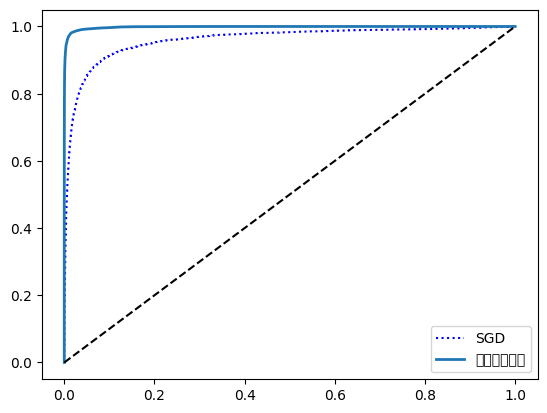

In [52]:
#ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤포레스트")
plt.legend(loc="lower right")
plt.show()

In [53]:
#랜덤이 왼쪽 위 모서리에 더 가까워 더 좋아보임, rocauc 점수도 더 높음
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##3.4 다중 분류

다중분류기: 둘이상의 클래스 구별

이미지 분류시 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택 : OvR 전략 / 각 숫자 조합마다 이진 분류기 훈련: OvO

In [54]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
#decision_funcion() 호출시 샘플당 10개의 점수 반환: 클래스마다 점수 하나씩
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [56]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [58]:
#OvO나 OvR 사용하려면 OneVsOneClassifier나 OneVsRestClassifier 사용
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [59]:
#SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [60]:
#sgd 분류기가 클래스마다 부여한 점수 확인
#큰 음수-> 예측결과에 강한 확신, 큰 양수: 의심
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
#교차검증으로 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
#입력 스케일 조정해 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_trainsform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

##3.5 에러 분석

그리드서치로 하이퍼파라미터 튜닝, 오차행렬 보기

In [ ]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#맷플롯립의 matshow()이용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#주대각선 밝으면 잘 분류된거-> 5가 좀 어두우면 이미지가 적거나 잘 분류 못한다는 것

row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

#주대각선만 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분류기가 만든 에러 볼수 있음, 행은 실제 클래스 열은 예측 클래스임 기억하기

-오차 행렬 분석해 분류기의 성능 향상 방안에 대한 통찰 얻을 수 있음-> 8로 잘못 분류되는 것 줄이도록 개선 필요: 8 데이터 보강

In [ ]:
cl_a, cl_b=3, 5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5)
plt.show()

선형모델인 SGDClassifier를 사용해서 잘못 분류-> 선형분류기는 클래스마다 픽셀에 가중치 할당, 새 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산하여 3과 5를 쉽게 혼동 가능

-에러 줄이려면 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리

##3.6 다중 레이블 분류

다중 레이블 분류: 여러개의 이진 꼬리표 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
#올바르게 분류됨: 숫자 5는 크지않고 false, 홀수 true
knn_clf.predict([some_digit])

In [ ]:
#모든 레이블에 대한 f1 점수의 평균 계산
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

레이블에 클래스의 지지도를 가중치로 주기(average="weighted"로 설정)

##3.7 다중출력분류

다중출력분류: 다중레이블분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화(즉 값을 두개 이상 가질 수 있음)

-> 이를 위해 이미지 잡음 제거 시스템 만들기

In [ ]:
#randint(): 픽셀강도에 잡음 추가 : 타깃이 원본이미지됨
noise=np.random.randint(0,100,(len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [ ]:
#분류기를 훈련시켜 이미지 깨끗하도록
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)